In [ ]:
# |default_exp text.modeling.language_modeling
# |default_cls_lvl 3

In [ ]:
# | nbflags skip_exec

In [ ]:
# |hide
%reload_ext autoreload
%autoreload 2

# Modeling

> The `text.modeling.language_modeling` module contains custom models, custom splitters, etc... for both causal and MLM language modeling tasks. This includes things like training BERT from scratch or fine-tuning a particular pre-trained LM on your own corpus.

In [ ]:
# |export
import ast, gc, inspect, os, warnings
from typing import Any, Callable, Dict, List, Optional, Union, Type

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import (
    DataBlock,
    ColReader,
    ItemGetter,
    ColSplitter,
    RandomSplitter,
)
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import perplexity
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar, master_bar
from sklearn.metrics import accuracy_score
from transformers import (
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    PretrainedConfig,
    PreTrainedTokenizerBase,
    PreTrainedModel,
)
from transformers.utils import logging as hf_logging

from blurr.text.data.core import TextDataLoader, TextBlock, first_blurr_tfm
from blurr.text.data.language_modeling import (
    BaseLMStrategy,
    LMBatchTokenizeTransform,
    LMPreprocessor,
    LMType,
    CausalLMTextInput,
    CausalLMStrategy,
    MLMTextInput,
    BertMLMStrategy,
)

from blurr.text.modeling.core import Blearner
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedCrossEntropyLoss

In [ ]:
# | hide
import pdb

from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbdev import nbdev_export
from nbdev.showdoc import show_doc

from blurr.utils import print_versions
from blurr.text.modeling.core import BaseModelWrapper, BaseModelCallback, blurr_splitter
from blurr.text.utils import BlurrText

What we're running with at the time this documentation was generated:
torch: 1.9.0+cu102
fastai: 2.7.9
transformers: 4.21.2


In [ ]:
# |export
# silence all the HF warnings
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()

In [ ]:
# | echo: false
NLP = BlurrText()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

In [ ]:
# |hide
# |cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #1: GeForce GTX 1080 Ti


## Setup

For this example, we'll use the `WIKITEXT_TINY` dataset available from fastai to demonstrate how to configure BLURR code for language modeling

In [ ]:
wiki_path = untar_data(URLs.WIKITEXT_TINY)

train_df = pd.read_csv(wiki_path / "train.csv", header=None)
valid_df = pd.read_csv(wiki_path / "test.csv", header=None)

train_df["is_valid"] = False
valid_df["is_valid"] = True

df = pd.concat([train_df, valid_df])

print(len(df))
df.head()

662


,0,is_valid
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z...",False
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re...",False
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit...",False
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch...",False
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ....",False


## Mid-level API

### `LMMetricsCallback` -

In [ ]:
# |export
class LMMetricsCallback(Callback):
    """A fastai friendly metric implemented as a callback so that we can handle use cases where we don't
    want to count tokens marked to be ignored or else not count batches where there are no targs
    """

    def __init__(self, **kwargs):
        self.run_before = Recorder

        self.custom_metrics_dict = {"lm_accuracy": None}
        self.do_setup = True

    def setup(self):
        # one time setup code here.
        if not self.do_setup:
            return

        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L(
            [
                ValueMetric(partial(self.metric_value, metric_key=k), k)
                for k in custom_metric_keys
            ]
        )
        self.learn.metrics = self.learn.metrics + custom_metrics

        self.do_setup = False

    def before_fit(self):
        self.setup()

    # --- batch begin/after phases ---
    def after_batch(self):
        # do this only for validation set
        if self.training or self.learn.y is None:
            return

        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0]  # yb is TensorText tuple, item 0 is the data

        msk = torch.where(targs != -100, 1, 0).bool()
        preds = torch.masked_select(preds, msk).cpu()
        targs = torch.masked_select(targs, msk).cpu()

        if preds.shape[0] == 0:
            return

        self.results += [(res[0], res[1]) for res in zip(preds, targs)]

    # --- validation begin/after phases ---
    def before_validate(self):
        self.results = []

    def after_validate(self):
        if len(self.results) < 1:
            return

        preds, targs = map(list, zip(*self.results))
        self.custom_metrics_dict["lm_accuracy"] = accuracy_score(targs, preds)

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key):
        return self.custom_metrics_dict[metric_key]

In this section, we'll add helpful metrics for calculating accuracy and perplexity for both causal and masked language modeling tasks.

### Examples

#### Causal Language Modeling

In causal language modeling, we are attempting to predict the next token given those before it.

In [ ]:
model_cls = AutoModelForCausalLM
hf_logging.set_verbosity_error()

pretrained_model_name = "gpt2"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls
)

if hf_tokenizer.pad_token is None:
    hf_tokenizer.pad_token = "[PAD]"

Using pad_token, but it is not set yet.


In [ ]:
preprocessor = LMPreprocessor(hf_tokenizer, chunk_size=128, text_attr=0)
proc_df = preprocessor.process_df(train_df, valid_df)

In [ ]:
bbtfm = LMBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=CausalLMStrategy
)
blocks = (
    TextBlock(batch_tokenize_tfm=bbtfm, input_return_type=CausalLMTextInput),
    noop,
)

dblock = DataBlock(
    blocks=blocks, get_x=ColReader("proc_0"), splitter=ColSplitter(col="is_valid")
)

In [ ]:
dls = dblock.dataloaders(proc_df, bs=2)

In [ ]:
b = dls.one_batch()
b[0]["input_ids"].shape, b[0]["labels"].shape, b[1].shape

(torch.Size([2, 129]), torch.Size([2, 129]), torch.Size([2, 129]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"₹ 40 million ( US $ 590 @,@ 000 ) was spent solely on VFX for Magadheera. \n \n = = = <unk> = = = \n \n During the film's shoot at Ramoji Film City in late November 2008, a 500 square feet ( 46 m2 ) film can, containing two or three scenes, was discovered missing from Rainbow lab. The filmmakers filed a case at <unk> police station. Security personnel and film unit members searched, but failed to recover the reels. Rajamouli's unit said it was not important if the scenes from","�� 40 million ( US $ 590 @,@ 000 ) was spent solely on VFX for Magadheera. \n \n = = = <unk> = = = \n \n During the film's shoot at Ramoji Film City in late November 2008, a 500 square feet ( 46 m2 ) film can, containing two or three scenes, was discovered missing from Rainbow lab. The filmmakers filed a case at <unk> police station. Security personnel and film unit members searched, but failed to recover the reels. Rajamouli's unit said it was not important if the scenes from"
1,"ology of Ritual and Magic was reviewed by John Hutchings for the Folklore journal, the published arm of The Folklore Society. He highlighted how the work would be of benefit to folklorists, by putting various charms then in museum exhibits – such as dead cats, buried shoes and witch bottles – into the wider context of ritual activity. He opined that it was "" a little disappointing "" that the examples were almost all from London and the Home Counties, but described the book as "" <unk> written, c","logy of Ritual and Magic was reviewed by John Hutchings for the Folklore journal, the published arm of The Folklore Society. He highlighted how the work would be of benefit to folklorists, by putting various charms then in museum exhibits – such as dead cats, buried shoes and witch bottles – into the wider context of ritual activity. He opined that it was "" a little disappointing "" that the examples were almost all from London and the Home Counties, but described the book as "" <unk> written, car"


##### Training

In [ ]:
model = BaseModelWrapper(hf_model)
fit_cbs = [LMMetricsCallback()]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),
    cbs=[BaseModelCallback],
    metrics=[perplexity],
    splitter=blurr_splitter,
).to_fp16()

learn.freeze()

In [ ]:
# | output: false
learn.summary()

BaseModelWrapper (Input shape: 2 x 129)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 129 x 768       
Embedding                                 38597376   False     
Embedding                                 786432     False     
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     2 x 129 x 2304      
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     2 x 129 x 3072      
Conv1D                                  

In [ ]:
# b = dls.one_batch()
# preds = learn.model(b[0])
# len(preds),preds[0], preds[1].shape

In [ ]:
print(len(learn.opt.param_groups))

5


SuggestedLRs(minimum=0.0013182567432522773, steep=3.311311274956097e-06, valley=0.0012022644514217973, slide=0.0030199517495930195)

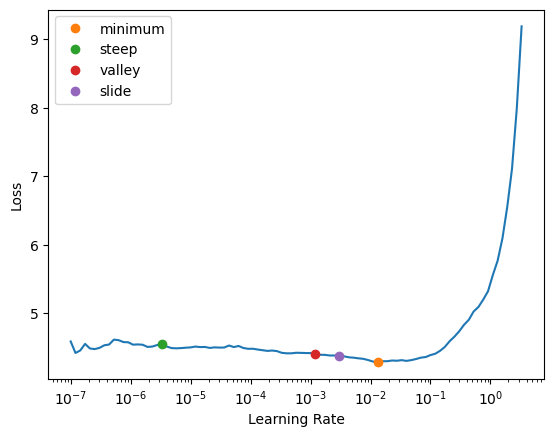

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-3, cbs=fit_cbs)

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,3.461066,3.167435,23.746506,0.417437,24:57


##### Showing results

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `HF_CausalLMInput` typed inputs
    x: CausalLMTextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs
):
    # grab our tokenizer and ignore token to decode
    tfm = first_blurr_tfm(learner.dls)

    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id

    res = L(
        [
            (
                hf_tokenizer.decode(s[0], skip_special_tokens=True)[:trunc_at],
                hf_tokenizer.decode(
                    s[1][s[1] != ignore_token_id], skip_special_tokens=True
                )[:trunc_at],
                hf_tokenizer.decode(pred[0], skip_special_tokens=True)[:trunc_at],
            )
            for s, pred in zip(samples, outs)
        ]
    )

    display_df(pd.DataFrame(res, columns=["text", "target", "prediction"])[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,". \n The German government has said that it does not consider Scientology a religion, but a "" commercial enterprise with a history of taking advantage of vulnerable individuals and an extreme dislike of any criticism "" whose "" totalitarian structure a","\n The German government has said that it does not consider Scientology a religion, but a "" commercial enterprise with a history of taking advantage of vulnerable individuals and an extreme dislike of any criticism "" whose "" totalitarian structure an","<\n < army was been that the is not want the to threat, but that "" cult organization "" a commercial of religious advantage of the individuals "" the interest religious of the form of. "" < ideology "" political "" be a threat to the ""s national system """
1,"the Japanese launched a heavy counter @-@ attack, which was turned back with heavy casualties. After this, the situation on <unk> became largely static, as the Japanese focused primarily on subsistence, and the US forces chose to adopt a mainly defe","Japanese launched a heavy counter @-@ attack, which was turned back with heavy casualties. After this, the situation on <unk> became largely static, as the Japanese focused primarily on subsistence, and the US forces chose to adopt a mainly defensiv","< < a series attackattack-@ attack on but was launched back by a fire. the, the Japanese was theunk> was more peaceful. with the Japanese were on on the farming and the Japanese and were to concentrate a more defensive strategy. on the the defensiv"


##### Prediction

In [ ]:
learn.blurr_generate(
    "Blurr is fun to work with because", max_length=50, do_sample=True, top_k=25
)

[{'generated_texts': ' Blurr is fun to work with because the way he moves and talks to the audience is reminiscent of the way he talks to an audience and the way he behaves . He has a tendency to laugh at himself and others , especially when his humor seems'}]

In [ ]:
# |hide
try:
    del learn
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

#### Masked Language Modeling

In masked language modeling (MLM), we are attempting to predict the ***masked*** tokens. In Blurr, these are encapsulated by classes implementing the `BaseLMStrategy` base class.

For a list of some of the more common strategies, see table 3 of the [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683) paper.  When fine-tuning a MLM model. you'll want to make sure you use the same approach as the model authors should you be looking to reproduce their results ... but our approach here makes it easy to play with different strategies regardless.

In the example below, we'll tell Blurr we want to use the BERT-style masking strategy.

In [ ]:
model_cls = AutoModelForMaskedLM
hf_logging.set_verbosity_error()

pretrained_model_name = "distilroberta-base"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls
)

if hf_tokenizer.pad_token is None:
    hf_tokenizer.pad_token = "[PAD]"

In [ ]:
preprocessor = LMPreprocessor(hf_tokenizer, chunk_size=128, text_attr=0)
proc_df = preprocessor.process_df(train_df, valid_df)

In [ ]:
bbtfm = LMBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=BertMLMStrategy
)
blocks = (TextBlock(batch_tokenize_tfm=bbtfm, input_return_type=MLMTextInput), noop)

dblock = DataBlock(
    blocks=blocks, get_x=ColReader("proc_0"), splitter=ColSplitter(col="is_valid")
)

In [ ]:
dls = dblock.dataloaders(proc_df, bs=2)

In [ ]:
b = dls.one_batch()
b[0]["input_ids"].shape, b[0]["labels"].shape, b[1].shape

(torch.Size([2, 130]), torch.Size([2, 130]), torch.Size([2, 130]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,"� � � [u] — wanted to forcibly retire officers with more than 25 years of service , as they thought <mask> to be and <mask> , <mask> most importantly , rivals for power . Most of the older officers had [ more] experience [ under] the Vietnamese National <mask> during the French colonial era , and some of [host] younger men saw them as <mask> detached <mask> <mask> modern situation . The Young Turks had quite a lot <mask> influence over Kh án h , as Th i and K � � � <mask> intervened milit <mask> to <mask> him from a coup attempt in September <mask> <mask> als <mask> V � � <mask> and D � � � � ng V � �","� � � [u] — wanted to forcibly retire officers with more than 25 years of service , as they thought [ them] to be and [ ineffective] , [ but] most importantly , rivals for power . Most of the older officers had [ more] experience [ under] the Vietnamese National [ Army] during the French colonial era , and some of [ the] younger men saw them as [ too] detached [ from] [ the] modern situation . The Young Turks had quite a lot [ of] influence over Kh án h , as Th i and K � � � [ had] intervened milit [arily] to [ save] him from a coup attempt in September [ by] [ Gener] als [ ] V � � [n] and D � � � � ng V � �"
1,"� � t wait <mask> a fresh start . "" Later in the <mask> , <mask> the Phillies won game five [,] a Brett Myers asked Ham els : "" What are [ you] doing <mask> ? I thought you quit . "" The Phillies <mask> the World Series <mask> the New York <mask> in six games . \n Rob <mask> <mask> and columnist for ESPN . com , [ contradicted] anyone who <mask> [ burgers] els ' <mask> had deteriorated , <mask> commenting <mask> \n "" Last October , everybody was ready to Ham els some sort of superhero . This was largely <mask> he went <mask> – 0 during the Phillies ' championship run , but","� � t wait [ for] a fresh start . "" Later in the [ series] , [ after] the Phillies won game five [,] a Brett Myers asked Ham els : "" What are [ you] doing [ here] ? I thought you quit . "" The Phillies [ lost] the World Series [ to] the New York [ Yankees] in six games . \n Rob [ a] [ ] and columnist for ESPN . com , [ contradicted] anyone who [ asserted] [ Ham] els ' [ skills] had deteriorated , [ instead] commenting [,] \n "" Last October , everybody was ready to Ham els some sort of superhero . This was largely [ because] he went [ 4] – 0 during the Phillies ' championship run , but"


##### Training

In [ ]:
model = BaseModelWrapper(hf_model)
fit_cbs = [LMMetricsCallback()]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam, decouple_wd=True),
    loss_func=PreCalculatedCrossEntropyLoss(),
    cbs=[BaseModelCallback],
    metrics=[perplexity],
    splitter=blurr_splitter,
).to_fp16()

learn.freeze()

In [ ]:
# | output: false
learn.summary()

BaseModelWrapper (Input shape: 2 x 130)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 130 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
         

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(minimum=7.585775847473997e-08, steep=0.0003311311302240938, valley=0.0014454397605732083, slide=0.04786301031708717)

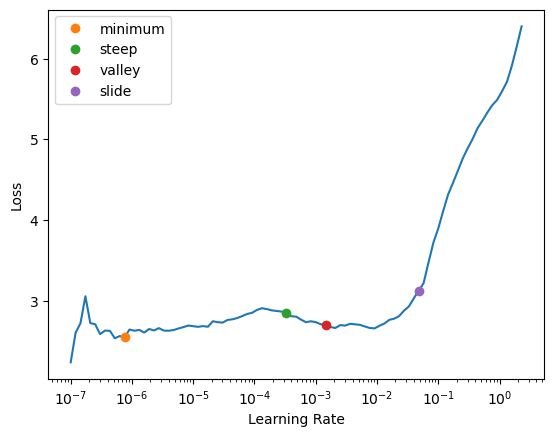

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,1.901993,1.800679,6.053758,0.638759,34:37


In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `HF_MLMInput` typed inputs
    x: MLMTextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer and ignore token to decode
    tfm = first_blurr_tfm(learner.dls)

    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id

    # grab our mask token id and do-not-mask token ids
    mask_token_id = hf_tokenizer.mask_token_id

    vocab = hf_tokenizer.get_vocab()
    dnm_tok_ids = [
        vocab[tok]
        for tok in list(hf_tokenizer.special_tokens_map.values())
        if vocab[tok] != mask_token_id
    ]

    res = L()
    for s, t in zip(samples, outs):
        # exclue dnm tokens from input
        inps = [
            hf_tokenizer.decode(tok_id)
            if (tok_id == mask_token_id or s[1][idx] == ignore_token_id)
            else f"[{hf_tokenizer.decode(tok_id)}]"
            for idx, tok_id in enumerate(s[0])
            if (tok_id not in dnm_tok_ids)
        ]

        # replaced masked tokens with "[{actual_token}]"
        trgs = [
            hf_tokenizer.decode(s[0][idx])
            if (tok_id == ignore_token_id)
            else f"[{hf_tokenizer.decode(tok_id)}]"
            for idx, tok_id in enumerate(s[1])
            if (s[0][idx] not in dnm_tok_ids)
        ]

        # same as above except we replace the [MASK] with the PREDICTED token
        preds = [
            hf_tokenizer.decode(s[0][idx])
            if (tok_id == ignore_token_id)
            else f"[{hf_tokenizer.decode(t[0][idx])}]"
            for idx, tok_id in enumerate(s[1])
            if (s[0][idx] not in dnm_tok_ids)
        ]

        res.append(
            (
                " ".join(inps[:trunc_at]).strip(),
                " ".join(trgs[:trunc_at]).strip(),
                " ".join(preds[:trunc_at]).strip(),
            )
        )

    display_df(pd.DataFrame(res, columns=["text", "target", "prediction"])[:max_n])
    return ctxs

##### Showing results

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"hostile when the <mask> ler ' <mask> presence <mask> to competition over resources , and to <mask> occupation [ of] the indigenous inhabitants ' lands . European diseases dec imated Aboriginal populations <mask> and the <mask> or destruction of [eper] and food <mask> [ sometimes] led to starvation . By <mask> large neither the <mask> nor the approached the conflict in an organised sense and conflict occurred between groups of settlers and individual tribes rather than systematic warfare . At times , <mask> , the <mask> wars did see the involvement of British soldiers <mask> later mounted [ police] units . Not all Aboriginal groups <mask> white encro achment <mask> their lands <mask> while many served in mounted police units and were involved in","hostile when the [ sett] ler ' [s] presence [ led] to competition over resources , and to [ the] occupation [ of] the indigenous inhabitants ' lands . European diseases dec imated Aboriginal populations [,] and the [ occupation] or destruction of [ lands] and food [ resources] [ sometimes] led to starvation . By [ and] large neither the [ British] nor the approached the conflict in an organised sense and conflict occurred between groups of settlers and individual tribes rather than systematic warfare . At times , [ however] , the [ frontier] wars did see the involvement of British soldiers [ and] later mounted [ police] units . Not all Aboriginal groups [ resisted] white encro achment [ on] their lands [,] while many served in mounted police units and were involved in","hostile when the [ sett] ler ' [s] presence [ led] to competition over resources , and to [ the] occupation [ of] the indigenous inhabitants ' lands . European diseases dec imated Aboriginal populations [,] and the [ theft] or destruction of [ crops] and food [ supplies] [ sometimes] led to starvation . By [ the] large neither the [ British] nor the approached the conflict in an organised sense and conflict occurred between groups of settlers and individual tribes rather than systematic warfare . At times , [ however] , the [ Indian] wars did see the involvement of British soldiers [ and] later mounted [ police] units . Not all Aboriginal groups [ saw] white encro achment [ on] their lands [,] while many served in mounted police units and were involved in"
1,", the two <mask> , [ along] with the Meridian Downtown Association , spearheaded the downtown effort . The Alliance serves as an umbrella organization , allowing the other two organizations to <mask> the its support [ staff] <mask> housing , and in turn <mask> Alliance serves <mask> a liaison between the organizations . Plans were <mask> to renov ate the Building , <mask> <mask> <mask> Mayor Barry killed the plans in early 2010 <mask> Today <mask> the Alliance helps to promote [ qual] development and restoration downtown <mask> its goal is to assist businesses such as specialty shops , restaurants , and bars [ because] these help downtown <mask> <mask> active <mask> the day and at night . The Meridian Downtown Association",", the two [ organizations] , [ along] with the Meridian Downtown Association , spearheaded the downtown effort . The Alliance serves as an umbrella organization , allowing the other two organizations to [ use] the its support [ staff] [ and] housing , and in turn [ the] Alliance serves [ as] a liaison between the organizations . Plans were [ underway] to renov ate the Building , [ but] [ newly] [ elected] Mayor Barry killed the plans in early 2010 [.] Today [,] the Alliance helps to promote [ further] development and restoration downtown [ ;] its goal is to assist businesses such as specialty shops , restaurants , and bars [ because] these help downtown [ become] [ more] active [ during] the day and at night . The Meridian Downtown Association",", the two [ organizations] , [ along] with the Meridian Downtown Association , spearheaded the downtown effort . The Alliance serves as an umbrella organization , allowing the

##### Prediction

While `Learner.blurr_generate` will work well for causal LMs designed for text generation, it won't for MLM models designed to predict masked tokens.  To accomodate the later, we add `Learner.blurr_fill_mask` ...

In [ ]:
# |export
@patch
def blurr_fill_mask(
    self: Learner,
    # Your input_ids or raw text string with a `hf_tokenizer.mask_token`
    inp: Union[List[int], str],
    # The number of predictions you want to return for the [MASK]ed token
    n_preds: int = 1,
    # Any other keyword arguments you want applied to text generation
    **kwargs
):
    """For MLM models"""
    # grab the Hugging Face tokenizer from the learner's dls.tfms
    tfm = first_blurr_tfm(self.dls)

    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    if isinstance(inp, str):
        input_ids = hf_tokenizer.encode(
            inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs
        )
    else:
        # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
        input_ids = inp.as_subclass(Tensor)

    input_ids = input_ids.to(self.model.hf_model.device)
    mask_token_index = torch.where(input_ids == hf_tokenizer.mask_token_id)[1]

    outputs = self.model.hf_model(input_ids)
    mask_token_logits = outputs.logits[0, mask_token_index, :]
    preds = torch.topk(mask_token_logits, n_preds, dim=-1).indices[0].tolist()

    outputs = [
        inp.replace(hf_tokenizer.mask_token, hf_tokenizer.decode([tok_id]).strip())
        for tok_id in preds
    ]

    return outputs

In [ ]:
learn.blurr_fill_mask(
    f"The best place on earth is {hf_tokenizer.mask_token}.", n_preds=5
)

['The best place on earth is here.',
 'The best place on earth is there.',
 'The best place on earth is America.',
 'The best place on earth is hell.',
 'The best place on earth is ours.']

In [ ]:
# |hide
try:
    del learn
    torch.cuda.empty_cache(), gc.collect()
except:
    pass

## High-level API

### `BlearnerForLM` -

In [ ]:
# |export
@delegates(Blearner.__init__)
class BlearnerForLM(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        kwargs["loss_func"] = kwargs.get("loss_func", PreCalculatedCrossEntropyLoss())
        super().__init__(dls, hf_model, **kwargs)

    @classmethod
    def get_model_cls(self, lm_type):
        return (
            AutoModelForCausalLM if (lm_type == LMType.CAUSAL) else AutoModelForMaskedLM
        )

    @classmethod
    def get_metrics_cb(self):
        return LMMetricsCallback()

    @classmethod
    def from_data(
        cls,
        # Your raw dataset. Supports DataFrames, Hugging Face Datasets, as well as file paths
        # to .csv, .xlsx, .xls, and .jsonl files
        data: Union[pd.DataFrame, Path, str, List[Dict]],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # The language modeling strategy (or objective)
        lm_strategy_cls: BaseLMStrategy = CausalLMStrategy,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Optional[Callable] = None,
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        # if we get a path/str then we're loading something like a .csv file
        if isinstance(data, Path) or isinstance(data, str):
            content_type = mimetypes.guess_type(data)[0]
            if (
                content_type
                == "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet"
            ):
                data = pd.read_excel(data)
            elif content_type == "text/csv":
                data = pd.read_csv(data)
            elif content_type == "application/json":
                data = pd.read_json(data, orient="records")
            else:
                raise ValueError("'data' must be a .xlsx, .xls, .csv, or .jsonl file")

            data = pd.read_csv(data)

        # infer our datablock splitter if None
        if dblock_splitter is None:
            dblock_splitter = (
                ColSplitter() if hasattr(data, "is_valid") else RandomSplitter()
            )

        # get our hf objects
        lm_type = lm_strategy_cls.get_lm_type()
        model_cls = cls.get_model_cls(lm_type=lm_type)
        hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
            pretrained_model_name_or_path, model_cls=model_cls
        )

        # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
        if hf_tokenizer.pad_token is None:
            hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
            hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
            hf_model.resize_token_embeddings(len(hf_tokenizer))

        # define DataBlock and DataLoaders
        bbtfm = LMBatchTokenizeTransform(
            hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=lm_strategy_cls
        )

        input_return_type = (
            CausalLMTextInput if (lm_type == LMType.CAUSAL) else MLMTextInput
        )
        blocks = (
            TextBlock(batch_tokenize_tfm=bbtfm, input_return_type=input_return_type),
            noop,
        )

        dblock = DataBlock(
            blocks=blocks, get_x=ItemGetter(text_attr), splitter=dblock_splitter
        )
        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance with default metrics (optional)
        learner_kwargs["metrics"] = learner_kwargs.pop("metrics", [perplexity])
        return cls(dls, hf_model, **learner_kwargs.copy())

We can use the `BlearnerForLM` for either Causal or Masked language models.  With one line of code, we get our DataBlock, DataLoaders, and Blearner with sensible defaults and ready for training

### Example

#### Causal language modeling

In [ ]:
learn = BlearnerForLM.from_data(df, "gpt2", text_attr=0, dl_kwargs={"bs": 2}).to_fp16()

Using pad_token, but it is not set yet.


In [ ]:
learn.dls.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=500)

,text,target
0,"\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest, although Dylan repudiated suggestions from journalists that he was a spokesman for his generation. Nevertheless, early songs such as "" Blowin'in the Wind "" and "" The Times They A","\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest, although Dylan repudiated suggestions from journalists that he was a spokesman for his generation. Nevertheless, early songs such as "" Blowin'in the Wind "" and "" The Times They Ar"
1,"\n = George Calvert, 1st Baron Baltimore = \n \n George Calvert, 1st Baron Baltimore ( <unk> – 15 April 1632 ) was an English politician and <unk>. He achieved domestic political success as a Member of Parliament and later Secretary of State under King James I. He lost much of his political power after his support for a failed marriage alliance between Prince Charles and the Spanish House of Habsburg royal family. Rather than continue in politics, he resigned all of his political offices in 1625 e","\n = George Calvert, 1st Baron Baltimore = \n \n George Calvert, 1st Baron Baltimore ( <unk> – 15 April 1632 ) was an English politician and <unk>. He achieved domestic political success as a Member of Parliament and later Secretary of State under King James I. He lost much of his political power after his support for a failed marriage alliance between Prince Charles and the Spanish House of Habsburg royal family. Rather than continue in politics, he resigned all of his political offices in 1625 ex"


In [ ]:
learn.fit_one_cycle(1, lr_max=3e-3, cbs=[BlearnerForLM.get_metrics_cb()])

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,3.530678,3.135360,22.996923,0.427218,02:35


In [ ]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"\n = Military history of Australia = \n \n The military history of Australia spans the nation's 220 @-@ year modern history, from the early Australian frontier wars between <unk> and Europeans to the ongoing conflicts in Iraq and Afghanistan in the ear","\n = Military history of Australia = \n \n The military history of Australia spans the nation's 220 @-@ year modern history, from the early Australian frontier wars between <unk> and Europeans to the ongoing conflicts in Iraq and Afghanistan in the earl",\n\n =\n = the\n\n\n =\n = Australian history of Australia is the period froms history- 1@ years period era. including the early days colonial to to the 18> Australia < < the early conflict between the and Afghanistan. the late 1980st century. The the histo
1,"\n = Air Rhodesia Flight <unk> = \n \n Air Rhodesia Flight <unk> was a scheduled passenger flight that was shot down by the Zimbabwe People's Revolutionary Army ( <unk> ) on 3 September 1978, during the Rhodesian Bush War. The aircraft involved, a Vick","\n = Air Rhodesia Flight <unk> = \n \n Air Rhodesia Flight <unk> was a scheduled passenger flight that was shot down by the Zimbabwe People's Revolutionary Army ( <unk> ) on 3 September 1978, during the Rhodesian Bush War. The aircraft involved, a Vicke",\n\n = Force\n\n\n\n> = Air\n =\n = Rhodesia Flight <unk> = a flight flight flight from was scheduled down by a Sovietan'ss Liberation Army (Zunk> ) in September August 1944. killing a liberationian civil War. The plane was in was civilian- aircraftickersoun


In [ ]:
learn.blurr_generate(
    "Blurr is fun to work with because", max_length=50, do_sample=True, top_k=25
)

[{'generated_texts': " Blurr is fun to work with because it it is it is the '\n\n- A bit of work in addition to playing is done at http:// @ www. @ https:// https:// @"}]

In [ ]:
# |hide
try:
    del learn
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

#### Masked language modeling

In [ ]:
learn = BlearnerForLM.from_data(
    df,
    "bert-base-cased",
    lm_strategy_cls=BertMLMStrategy,
    text_attr=0,
    dl_kwargs={"bs": 2},
).to_fp16()

In [ ]:
learn.dls.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"= Bob [MASK] = Bob Dylan ( / [<] un ##k > / ; born Robert Allen [MASK] ##immer [MASK] , May 24 , 1941 [MASK] is an American singer @ [MASK] @ songwriter , artist [MASK] writer . He [MASK] been influential in popular music [MASK] culture for more than five decades . [MASK] of his most celebrated work dates from the 1960s when his [MASK] [MASK] ##d social unrest , although Dylan re ##pu ##dia ##ted suggestions from journalists that he was a spokesman for his generation . Nevertheless , early songs such as "" B ##low ##in ' in [the] Wind "" [MASK] "" The Times They Are a @ - @ < un ##k > ' "" became anthem ##s [MASK] the American civil rights and anti @ [-] @ war movements . After he left his initial base in the American folk music revival , his [missions] @ - @ minute single "" Like a [Rolling] Stone [MASK] altered the range of popular music [MASK] 1965 . His [MASK] @ - @ [MASK] recordings , backed by rock musicians , reached the top end of the United States music charts while also [perpendicular] < un ##k > and [MASK] from others in [MASK] folk movement . Dylan ' s lyrics have incorporated various political [glued] social [MASK] philosophical , and [MASK] influences . They def ##ied existing pop music conventions and [MASK] to the b ##urge ##oning counter ##culture . Initially inspired by the performances","= Bob [Dylan] = Bob Dylan ( / [<] un ##k > / ; born Robert Allen [Z] ##immer [##man] , May 24 , 1941 [)] is an American singer @ [-] @ songwriter , artist [and] writer . He [has] been influential in popular music [and] culture for more than five decades . [Much] of his most celebrated work dates from the 1960s when his [songs] [chronicle] ##d social unrest , although Dylan re ##pu ##dia ##ted suggestions from journalists that he was a spokesman for his generation . Nevertheless , early songs such as "" B ##low ##in ' in [the] Wind "" [and] "" The Times They Are a @ - @ < un ##k > ' "" became anthem ##s [for] the American civil rights and anti @ [-] @ war movements . After he left his initial base in the American folk music revival , his [six] @ - @ minute single "" Like a [Rolling] Stone [""] altered the range of popular music [in] 1965 . His [mid] @ - @ [1960s] recordings , backed by rock musicians , reached the top end of the United States music charts while also [attracting] < un ##k > and [criticism] from others in [the] folk movement . Dylan ' s lyrics have incorporated various political [,] social [,] philosophical , and [literary] influences . They def ##ied existing pop music conventions and [appealed] to the b ##urge ##oning counter ##culture . Initially inspired by the performances"
1,"= George [MASK] , 1st Baron Baltimore = George Calvert , 1st Baron Baltimore [MASK] < un ##k > – 15 April 163 ##2 ) was an [English] politician and < [##ortex] [MASK] > . He achieved domestic political success [MASK] [MASK] [MASK] of Parliament and later Secretary [##年] State under King James I [MASK] He lost much of his [political] power [MASK] his support for a [MASK] marriage alliance between Prince Charles and the Spanish House of Habsburg royal family . Rather than continue in [MASK] , he resigned all [MASK] his [MASK] offices [MASK] 162 ##5 except for his position on the Privy Council and declared his Catholicism publicly . He was created Baron Baltimore in [MASK] Irish peer ##age upon his resignation . Baltimore [MASK] was located in County Long ##ford , Ireland . Calvert took an interest in [MASK] British colonization of the Americas , [MASK] first for commercial reasons [MASK] later to create a refuge for English [MASK] [MASK] He became [MASK] proprietor of Avalon , the first sustained English settlement on the southeastern [MASK] on [MASK] island of [MASK] ( off the eastern coast of modern Canada ) . < un ##k > by its cold [MASK] sometimes in ##hos [MASK] ##able climate and the < un ##k [MASK] of [MASK] settlers , Sir George [MASK] for a more suitable spot further south [MASK] sought [MASK] new royal charter

In [ ]:
learn.fit_one_cycle(1, lr_max=6e-4, cbs=[BlearnerForLM.get_metrics_cb()])

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,2.676882,2.456665,11.665836,0.581747,01:03


In [ ]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"= Military [MASK] of Australia = [MASK] military history of Australia [MASK] the nation ' [Shawn] 220 [MASK] - @ year modern history , from the early Australian frontier [MASK] between < un ##k [MASK] and Europeans to the [MASK] conflicts in Iraq and Afghanistan in [MASK] early 21st century . Although this history is short when compared [MASK] that of many other nations , Australia has been involved [‑] numerous conflicts and wars [MASK] and war and military service [MASK] been [MASK] influences on Australian [MASK] and national identity , [tablets] the An ##zac spirit [.] The relationship between war and Australian society has also been [MASK] by the enduring themes of Australian strategic culture [MASK] its unique security [MASK] ##lemma . As [##aman] [MASK] un [##k] > , the Australian colonies participated in [MASK] ' s small wars of the 19th century [MASK] while later as a < un [MASK] > do ##mini ##on , and then an independent nation , [MASK] fought [MASK] the First World War and Second World [MASK] , as well as in the wars in Korea , Malaya , Borneo and Vietnam during the Cold War . In the [MASK] [MASK] - @ [MASK] [era] Australian forces [MASK] been involved in [##↑] international peace ##keeping missions , through the United Nations and [MASK] agencies , including in the Sinai , [MASK] Gulf , < [MASK] ##k > , Somalia , East Timor and the Solomon Islands , while more recently they have also","= Military [history] of Australia = [The] military history of Australia [spans] the nation ' [s] 220 [@] - @ year modern history , from the early Australian frontier [wars] between < un ##k [>] and Europeans to the [ongoing] conflicts in Iraq and Afghanistan in [the] early 21st century . Although this history is short when compared [to] that of many other nations , Australia has been involved [in] numerous conflicts and wars [,] and war and military service [have] been [significant] influences on Australian [society] and national identity , [including] the An ##zac spirit [.] The relationship between war and Australian society has also been [shaped] by the enduring themes of Australian strategic culture [and] its unique security [di] ##lemma . As [British] [<] un [##k] > , the Australian colonies participated in [Britain] ' s small wars of the 19th century [,] while later as a < un [##k] > do ##mini ##on , and then an independent nation , [Australia] fought [in] the First World War and Second World [War] , as well as in the wars in Korea , Malaya , Borneo and Vietnam during the Cold War . In the [Post] [@] - @ [Vietnam] [era] Australian forces [have] been involved in [numerous] international peace ##keeping missions , through the United Nations and [other] agencies , including in the Sinai , [Persian] Gulf , < [un] ##k > , Somalia , East Timor and the Solomon Islands , while more recently they have also","= Military [history] of Australia = [The] military history of Australia [and] the nation ' [s] 220 [@] - @ year modern history , from the early Australian frontier [wars] between < un ##k [>] and Europeans to the [military] conflicts in Iraq and Afghanistan in [the] early 21st century . Although this history is short when compared [to] that of many other nations , Australia has been involved [in] numerous conflicts and wars [,] and war and military service [have] been [important] influences on Australian [culture] and national identity , [particularly] the An ##zac spirit [.] The relationship between war and Australian society has also been [shaped] by the enduring themes of Australian strategic culture [and] its unique security [di] ##lemma . As [<] [<] un [##k] > , the Australian colonies participated in [Australia] ' s small wars of the 19th century [,] while later as a < un [##k] > do ##mini ##on , and then an independent nation , [Australia] fought [in] the First World War and Second World [War] , as well as in the wars in Korea , Malaya , Borneo and Vietnam during the Cold War . In the [post] [@] - @

In [ ]:
batch_tfm = first_blurr_tfm(learn.dls)

In [ ]:
learn.blurr_fill_mask(
    f"The best place on earth is {batch_tfm.hf_tokenizer.mask_token}.", n_preds=5
)

['The best place on earth is heaven.',
 'The best place on earth is here.',
 'The best place on earth is Egypt.',
 'The best place on earth is there.',
 'The best place on earth is Heaven.']

In [ ]:
# |hide
try:
    del learn
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

## Export -

In [ ]:
# |hide
nbdev_export()